In [1]:
!pip install transformers


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
!pip install datasets



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [4]:
from datasets import load_dataset

# Load the SST-2 dataset
dataset = load_dataset('glue', 'sst2')
train_dataset = dataset['train'].select(range(500))
test_dataset = dataset['validation'].select(range(100))






/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [5]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_dataset['sentence'], truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_dataset['sentence'], truncation=True, padding=True, max_length=128)






tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
model = TFAutoModel.from_pretrained("bert-base-uncased")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [7]:
# Convert the encodings to TensorFlow datasets
train_dataset_tf = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_dataset['label']
))
test_dataset_tf = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_dataset['label']
))

# Shuffle and batch the datasets
train_dataset_tf = train_dataset_tf.shuffle(1000).batch(16)
test_dataset_tf = test_dataset_tf.batch(16)


In [8]:
from transformers import TFBertForSequenceClassification

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


In [10]:
history = model.fit(train_dataset_tf, epochs=3, validation_data=test_dataset_tf)


Epoch 1/3
32/32 [==============================] - 379s 11s/step - loss: 0.6264 - accuracy: 0.6340 - val_loss: 0.4275 - val_accuracy: 0.8100
Epoch 2/3
32/32 [==============================] - 351s 11s/step - loss: 0.3294 - accuracy: 0.8820 - val_loss: 0.6918 - val_accuracy: 0.7200
Epoch 3/3
32/32 [==============================] - 328s 10s/step - loss: 0.1442 - accuracy: 0.9480 - val_loss: 0.3203 - val_accuracy: 0.8800


In [11]:
predictions = model.predict(test_dataset_tf).logits
predicted_classes = np.argmax(predictions, axis=1)


7/7 [==============================] - 50s 5s/step


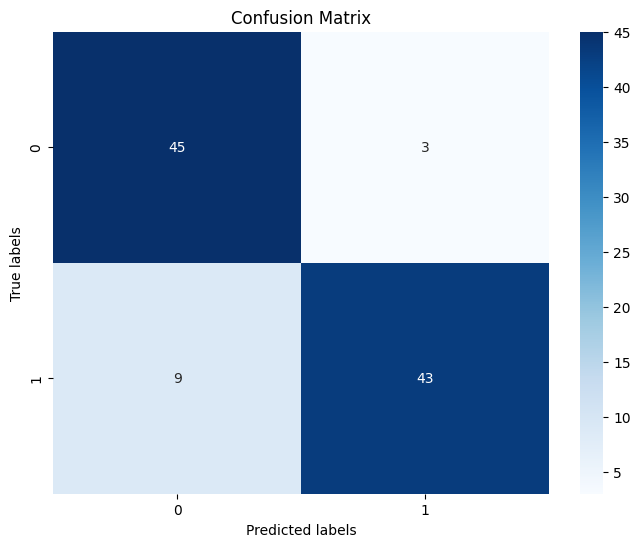

Text: you wonder why enough was n't just a music video rather than a full-length movie . 

True Label: Negative
Predicted Label: Negative
--------------------------------------------------
Text: there 's ... tremendous energy from the cast , a sense of playfulness and excitement that seems appropriate . 

True Label: Positive
Predicted Label: Positive
--------------------------------------------------
Text: manages to be both repulsively sadistic and mundane . 

True Label: Negative
Predicted Label: Negative
--------------------------------------------------
Text: you do n't have to know about music to appreciate the film 's easygoing blend of comedy and romance . 

True Label: Positive
Predicted Label: Positive
--------------------------------------------------
Text: we know the plot 's a little crazy , but it held my interest from start to finish . 

True Label: Positive
Predicted Label: Negative
--------------------------------------------------
Text: the primitive force of this fil

In [12]:
# Calculate the confusion matrix
cm = confusion_matrix(test_dataset['label'], predicted_classes)

# Display using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Choose a few random samples from the test set
num_samples = 10
sample_indices = np.random.choice(len(test_dataset), size=num_samples, replace=False)
sample_texts = [test_dataset['sentence'][i] for i in sample_indices]
sample_true_labels = [test_dataset['label'][i] for i in sample_indices]
sample_predictions = [predicted_classes[i] for i in sample_indices]

for text, true_label, predicted_label in zip(sample_texts, sample_true_labels, sample_predictions):
    print(f"Text: {text}\n")
    print(f"True Label: {'Positive' if true_label == 1 else 'Negative'}")
    print(f"Predicted Label: {'Positive' if predicted_label == 1 else 'Negative'}")
    print("-"*50)

